In this notebook, we will demonstrate how to use the tensorflow low level API to build a deep learning model to predict movie rating from scratch.

Our dataset: movielens 1m dataset.
Our parameters: movie embeddings, user embeddings, weights and bias in DNN.
Our Model: 

1. 4 layer neural network, with activation function: relu, relu, relu, softmax.
2. Input layer is the element wise prodcut of the user embedding and the movie embedding.
3. Cost function: a combination of cross entropy and mean squared error.
4. User embedding and movie embedding will be initialized with the results from matrix factorization model.
5. First 50 epochs only update weights and bias in DNN, from 51th epoch train model end-to-end.

In [4]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from __future__ import print_function

### download movie data and create model directory

In [5]:
# download movie data and make directory for the model

#! wget -q http://files.grouplens.org/datasets/movielens/ml-1m.zip
#! unzip ml-1m.zip
! mkdir mf_model
!mkdir cache

mkdir: mf_model: File exists
mkdir: cache: File exists


### data processing

step 1: load data to pandas dataframes, merge the dataframes to one table.

In [6]:
age_desc = {
    1: "Under 18", 18: "18-24", 25: "25-34", 35: "35-44", 45: "45-49", 50: "50-55", 56: "56+"
}
occupation_desc = { 
    0: "other or not specified", 1: "academic/educator", 2: "artist", 3: "clerical/admin",
    4: "college/grad student", 5: "customer service", 6: "doctor/health care",
    7: "executive/managerial", 8: "farmer", 9: "homemaker", 10: "K-12 student", 11: "lawyer",
    12: "programmer", 13: "retired", 14: "sales/marketing", 15: "scientist", 16: "self-employed",
    17: "technician/engineer", 18: "tradesman/craftsman", 19: "unemployed", 20: "writer"
}
rating_data = pd.read_csv(
    "ml-1m/ratings.dat",
    sep="::",
    engine="python",
    encoding="latin-1",
    names=['userid', 'movieid', 'rating', 'timestamp'])

user_data = pd.read_csv(
    "ml-1m/users.dat", 
    sep='::', 
    engine='python', 
    encoding='latin-1',
    names=['userid', 'gender', 'age', 'occupation', 'zipcode']
)
user_data['age_desc'] = user_data['age'].apply(lambda x: age_desc[x])
user_data['occ_desc'] = user_data['occupation'].apply(lambda x: occupation_desc[x])

movie_data = pd.read_csv(
    "ml-1m/movies.dat",
    sep='::', 
    engine='python', 
    encoding='latin-1',
    names=['movieid', 'title', 'genre']
)

dataset = pd.merge(pd.merge(rating_data, movie_data, how="left", on="movieid"), user_data, how="left", on="userid")

Step 2: preprocess the movie id and user id

In [7]:
def check_cols(df, cols):
    """
    checks if there are gaps of index, and if the index starts from 0
    
    Arguments:
    df -- dataframe of the dataset
    cols -- dataframe columns that needs to be checked, in our case user id and movie id
    
    Returns:
    a list of tuple [('COLUMN_NAME', boolean)], if True, the column needs to be fixed, if False, the column is ok.
    """
    return [(col, False) if len(dataset[col].unique())-1 == dataset[col].max() else (col, True) for col in cols]

def remove_gaps(df, col):
    """
    preprocess the index of user id and movie id to start from 0 and reduce the gap of index
    
    Arguments:
    df -- dataframe of the dataset
    col -- dataframe columns that needs to be adjusted, in our case both user id and movie id
    
    Returns:
    a dataframe with adjusted columns.
    """
    adj_col_uni = df[col].sort_values().unique()
    adj_df = pd.DataFrame(adj_col_uni).reset_index().rename(columns = {0: col, 'index': "adj_%s"%(col,)})
    return pd.merge(adj_df, df, how="right", on=col)

In [8]:
index_cols = ["userid", "movieid"]
cols_check = check_cols(dataset, index_cols)
print_check = lambda check: print(*["%s needs fix!"%(c,) if f else "%s ok."%(c,) for c, f in check], sep="\n")
print("before fix:")
print_check(cols_check)
for col, needs_fix in cols_check:
    if needs_fix:
        dataset = remove_gaps(dataset, col)

print("\nafter fix")
print_check(check_cols(dataset, ["adj_userid", "adj_movieid"]))

before fix:
userid needs fix!
movieid needs fix!

after fix
adj_userid ok.
adj_movieid ok.


step 3: shuffle data and split the data to train and validation set.

In [9]:
dataset = dataset.sample(frac=1, replace=False)
n_split = int(len(dataset)*.7)
trainset = dataset[:n_split]
validset = dataset[n_split:]

### Build Matrix Factorization Model 

In [10]:
def initialize_features(num_users, num_movies, dim):
    """
    Initialize features. User_features and movie_features need to be trained by the matrix factorization model.
    
    Arguments:
    num_users -- number of users
    num_movies -- number of movies
    dim -- dimension of learned user and movie features, it's a hyper-parameter
    
    Returns:
    user_features -- a matrix (variable) of shape [number of users, dim]
    movie_features -- a matrix (variable) of shape [number of movies, dim]
    """ 
    user_features = tf.get_variable(
        "theta",
        shape = [num_users, dim],
        dtype = tf.float32,
        initializer = tf.truncated_normal_initializer(mean=0, stddev=.05)
    )
    movie_features = tf.get_variable(
        "phi",
        shape = [num_movies, dim],
        dtype = tf.float32,
        initializer = tf.truncated_normal_initializer(mean=0, stddev=.05)
    )
    return user_features, movie_features

def create_dataset(user_ids, movie_ids, ratings):
    """
    Load user id, movie id and rating values. Turn numpy array to tensors.
    
    Arguments:
    user_ids -- user index
    movie_ids -- movies index
    ratings -- true rating value
    
    Returns:
    user_id_var -- a constant of shape [number of training examples, 1]
    movie_id_var -- a constant of shape [number of training examples, 1]
    ratings_var -- a constant of shape [number of training examples, 1]
    """ 
    user_id_var = tf.constant(name="userid", value=user_ids)
    movie_id_var = tf.constant(name="movieid", value=movie_ids)
    ratings_var = tf.constant(name="ratings", value=np.asarray(ratings, dtype=np.float32))
    return user_id_var, movie_id_var, ratings_var
   
def lookup_features(user_features, movie_features, user_ids, movie_ids): 
    """
    Retrieve embeddings based on user ids and movie ids respectively.
    We use tf.gather function for this. tf.gather gathers slices from params according to indices.
    
    Arguments:
    user_features -- shape [number of user ids, dim]
    movie_features -- shape [number of movie ids, dim]
    user_ids -- user id tensor (in our case loaded user ids from dataset)
    movie_ids -- movie id tensor (in our case loaded movie ids from dataset)
    
    Returns:
    selected_user_features -- a tensor of shape [number of examples, dim]
    selected_movie_features -- a tensor of shape [number of examples, dim]
    """ 
    selected_user_features = tf.gather(user_features, user_ids)
    selected_movie_features = tf.gather(movie_features, movie_ids)
    return selected_user_features, selected_movie_features

def predict(selected_user_features, selected_movie_features):
    """
    Calculate predictions. This is the dot product of user features and movie features. 
    For each training example, this corresponds to a single number.
    
    Arguments:
    selected_user_features -- matrix of user features for each example -- shape [number of examples, dim]
    selected_movie_features -- matrix of movies features value for each example -- shape [number of examples, dim]
    
    Returns:
    selected_predictions -- a tensor of shape [number of examples, 1]
    """ 
    selected_predictions = tf.reduce_sum(
        selected_user_features * selected_movie_features,
        axis = 1
    )
    ##alternatively, using tf.reduce_sum(tf.multiply(selected_user_embeddings,selected_movie_embeddings), axis=1)
    return selected_predictions

def mean_squared_difference(predictions, ratings):
    """
    Calculate cost.
    
    Arguments:
    predictions -- predicted ratings.
    ratings -- true ratings.
    
    Returns:
    difference -- mean squared error. It's a real number. 
    """ 
    difference = tf.reduce_mean(tf.squared_difference(predictions, ratings))
    return difference

### Train the Matrix Factorization Model

Here we train the matrix factorization model and save the final user features and movie features value for DNN. 

In [11]:
emb_dim = 8
mf_learning_rate = 50
mf_epochs = 1400

n_users = len(dataset.adj_userid.unique())
n_movies = len(dataset.adj_movieid.unique())

def mf_train(emb_dim, n_users, n_movies, trainset, validset, learning_rate, epochs):
    with tf.Graph().as_default():
        with tf.variable_scope("features"):
            usr_embs, mov_embs = initialize_features(len(dataset.adj_userid.unique()), len(dataset.adj_movieid.unique()), emb_dim)
        with tf.variable_scope("train_set"):
            train_data = trainset[["adj_userid", "adj_movieid", "rating"]].values.T #shape(3, 700146)
            train_usr_ids, train_mov_ids, train_ratings = create_dataset(*train_data)# expend to 3 lists
        with tf.variable_scope("valid_set"):
            valid_data = validset[["adj_userid", "adj_movieid", "rating"]].values.T
            valid_usr_ids, valid_mov_ids, valid_ratings = create_dataset(*valid_data)
        with tf.variable_scope("training"):
            train_sel_usr_emb, train_sel_mov_emb = lookup_features(usr_embs, mov_embs, train_usr_ids, train_mov_ids)
            train_preds = predict(train_sel_usr_emb, train_sel_mov_emb)
            train_loss = mean_squared_difference(train_preds, train_ratings)
            optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
            train_usr_embs = optimizer.minimize(train_loss, var_list=[usr_embs])
            train_mov_embs = optimizer.minimize(train_loss, var_list=[mov_embs])   
        with tf.variable_scope("validation"):
            valid_sel_usr_emb, valid_sel_mov_emb = lookup_features(usr_embs, mov_embs, valid_usr_ids, valid_mov_ids)
            valid_preds = predict(valid_sel_usr_emb, valid_sel_mov_emb)
            valid_loss = mean_squared_difference(valid_preds, valid_ratings)
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            train_loss_history = []
            valid_loss_history = []
            for i in range(epochs):
                current_train_loss, _ = sess.run([train_loss, train_usr_embs])
                current_train_loss, _ = sess.run([train_loss, train_mov_embs])
                current_valid_loss = sess.run(valid_loss)
                if i%50 == 0:
                    print("valid loss at step %i: %f"%(i+1, current_valid_loss))
                train_loss_history.append(current_train_loss)
                valid_loss_history.append(current_valid_loss)
            final_user_embeddings, final_movie_embeddings = sess.run([usr_embs, mov_embs])
            final_valid_predictions = sess.run(valid_preds)
    return (final_user_embeddings, final_movie_embeddings, train_loss_history, valid_loss_history, final_valid_predictions)

mf_result = mf_train(emb_dim, n_users, n_movies, trainset, validset, mf_learning_rate, mf_epochs)
mf_user_embs, mf_movie_embs, mf_tlh, mf_vlh, mf_fvp = mf_result

np.save("mf_model/user_features", mf_user_embs)
np.save("mf_model/movie_features", mf_movie_embs)

print("features saved")

valid loss at step 1: 14.081106
valid loss at step 51: 2.302089
valid loss at step 101: 1.051226
valid loss at step 151: 0.915825
valid loss at step 201: 0.874883
valid loss at step 251: 0.853326
valid loss at step 301: 0.835404
valid loss at step 351: 0.819504
valid loss at step 401: 0.806810
valid loss at step 451: 0.796939
valid loss at step 501: 0.789348
valid loss at step 551: 0.783548
valid loss at step 601: 0.779103
valid loss at step 651: 0.775642
valid loss at step 701: 0.772873
valid loss at step 751: 0.770588
valid loss at step 801: 0.768640
valid loss at step 851: 0.766956
valid loss at step 901: 0.765503
valid loss at step 951: 0.764257
valid loss at step 1001: 0.763205
valid loss at step 1051: 0.762334
valid loss at step 1101: 0.761629
valid loss at step 1151: 0.761072
valid loss at step 1201: 0.760648
valid loss at step 1251: 0.760338
valid loss at step 1301: 0.760131
valid loss at step 1351: 0.760016
features saved


### plot losses

plot the traing loss and valid loss

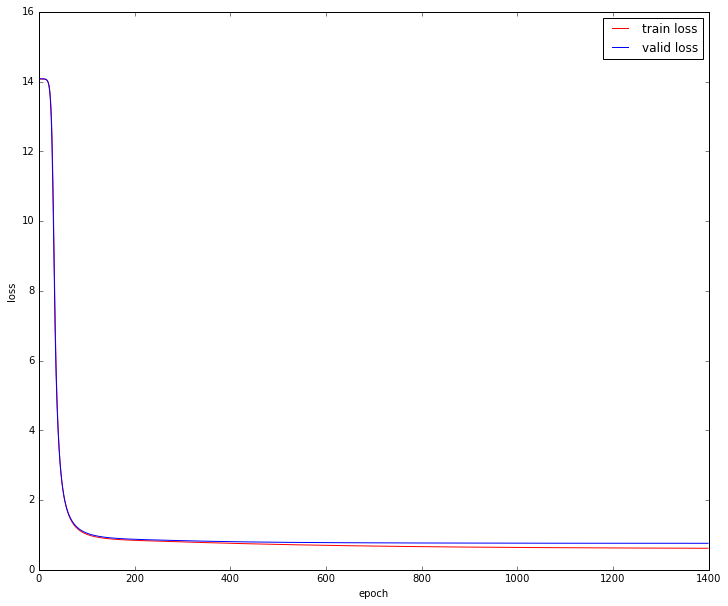

In [43]:
plt.figure(figsize=(12,10))
plt.plot(np.array(mf_tlh), color="red", label="train loss")
plt.plot(np.array(mf_vlh), color="blue", label="valid loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

### build DNN

Some notation first:
 - We have layers $1,...,n$ of our neural network
 - $W_i$ and $b_i$ are the weights and biases for the $i^{th}$ layer of our DNN. $W_1$ is the weight matrix of first layer. $W_n$ is the weight matrix of last layer.
 - for the $i^{th}$ layer of neural network, if $d_{in}$ is the dimension of input layer, $d_{out}$ is the dimension of output layer, then the dimension of $W_i$ is [$d_{in}$, $d_{out}$] and the dimension of $b_i$ is [$1$, $d_{out}$]
 - $z_i$ is the linear unit of the output from the previous layer: $z_i$ = $a_{i-1}\cdot W_i + b_i$
 - $a_i$ is the activation unit of $z_i$: if $f_i$ is the action function of ith layer: $a_i = f_i(z_i)$
 

In order to build the DNN, the steps below are followed:
1. load the movie and user embeddings from the results learned in matrix factorization model
2. initialize the DNN parameters
3. calculate the logits $z_n$ (linear output of last hidden layer)
4. calculate the predictions $softmax(z_n)$
5. calculate the loss
6. train and validate the model

### 1. load the movie and user embeddings

In [44]:
def load_embeddings(user_embs_file, movie_embs_file):
    """
    In the deep model we initialize the user embedding and movie embedding with value that learned from the matrix 
    factorization model. So here load already saved values. 
    
    Arguments:
    user_embs_file -- saved user embedding file name
    movie_embs_file -- saved movie embedding file name
    
    Returns:
    usr_embs -- initialized user embeddings array
    mov_embs -- initialized user embeddings array
    """       

    usr_embs_array = np.load(user_embs_file)
    mov_embs_array = np.load(movie_embs_file)
    usr_embs = tf.get_variable(
        "usr_embs",
        initializer = tf.constant_initializer(usr_embs_array),
        shape = usr_embs_array.shape
    )
    mov_embs = tf.get_variable(
        "mov_embs",
        initializer = tf.constant_initializer(mov_embs_array),
        shape = mov_embs_array.shape
    )
    return (usr_embs, mov_embs)

### 2. initialize the DNN parameters

before start explain the forward propagation, w and b dimensions.

In [45]:
def initialize_nn_params(net_dims):
    """
    initializes parameter Ws and bs for the whole NN. 

    net_dims -- layer dimensions, it's a list looks like [dim_input, d_1, ..., d_n]

    Returns:
    params -- a dictionary of variables containing W1, b1, ..., Wn, bn
    """
    
    #We first zip the two lists of net_dims to get the list of tuples (d_in, d_out) for each layer.
    #enumerate allows us to loop over something and have an automatic counter, in this case we use the counter as the 
    #index of W and b and we use the tuple (d_in, d_out) for the shape of our W and b.
    layer_dims = list(zip(net_dims[:-1], net_dims[1:]))
    params = {}
    for i, (d_in, d_out) in enumerate(layer_dims):
        params["W"+str(i+1)] = tf.get_variable(
            "W"+str(i+1), 
            [d_in, d_out], 
            initializer = tf.contrib.layers.xavier_initializer(seed =1)
        )
        params["b"+str(i+1)] = tf.get_variable(
            "b"+str(i+1), 
            [1,d_out], 
            initializer = tf.zeros_initializer()
        )
    return params

### 3. calculate the linear ouput of the last linear unit

In [46]:
def create_inputs(user_embeddings, movie_embeddings, user_ids, movie_ids):
    """
    use the lookup_embeddings function defined above to look up the embeddings based on the ids for the whole dataset.
    
    Arguments:
    user_embeddings -- shape [number of users, dim]
    movie_embeddings -- shape [number of movie, dim]
    user_ids -- user id variable, loaded user id from dataset
    movie_ids -- movie id variable, loaded movie id from dataset
    
    Returns:
    inputs --  input layer of the NN, shape [number of examples, dimension of the embeddings] 
    """
    sel_usr_embs, sel_mov_embs = lookup_features(user_embeddings, movie_embeddings, user_ids, movie_ids)
    inputs = sel_usr_embs * sel_mov_embs
    return inputs

def forward_propagate(inputs, params, acts, net_dims):
    """
    propagate the inputs through the network: INPUTS -> LINEAR_1 -> ACT_1 -> ... -> LINEAR_N
    
    Arguments:
    inputs -- the user and movie embedding
    params -- python dictionary containing parameters W1, b1, ..., Wn, bn as returned by initialize_nn_params
    acts -- list of activation functions, e.g.['tf.nn.relu', 'tf.nn.relu', 'None'] (None means linear activation)
    net_dims -- layer dimensions, it's a list looks like [dim_input, d_1, ..., d_n]

    Returns:
    a -- the output of the last hidden layer
    """
    a = inputs
    n_layers = len(net_dims)-1
    for i in range(n_layers):
        W = params['W'+str(i+1)]
        b = params['b'+str(i+1)]
        z = tf.matmul(a, W) + b
        a = acts[i](z) if acts[i] is not None else z
    return a

### 4. calculate the prediction

In [47]:
def calc_predict(logits):
    """
    calculates predictions, wraps tf.nn.softmax for documentation purposes.
    
    Arguments:
    logits -- tensor of logits, for example the (linear) output of the last hidden layer of a NN

    Returns:
    prediction -- softmax of logits, represents probability of each category, shape (number of examples, 5)
    """
    return tf.nn.softmax(logits)

### 5. calculate the loss

The loss is a combination of cross entropy and mean squared error.

In [48]:
def cross_entropy(logits, ratings):
    """
    computes the cross entropy.
    
    Arguments:
    logits -- tensor of logits, for example the (linear) output of the last hidden layer of a NN of
              shape (number of examples, 5)
    y -- "true" labels, densely encoded starting from 1, shape of (number of examples, 1). This will be our true
              ratings, i.e. [4,5,3,5,1,...]
    
    Returns:
    cross_entropy - scalar, mean cross entropy across examples
    """
    labels = ratings-1
    labels = tf.cast(labels,tf.int32)
    cross_entropy = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    
    return cross_entropy

def mean_squared_error(predictions, ratings):
    """
    computes the mean squared error.
     
     
    Arguments:
    prediction -- predicted value, shape (number of examples, 5)
    rating -- "true" labels, shape (number of examples, 5)
    
    Returns:
    mean_distance -- mean squared error 
    """
    
    #tf.expand_dims returns a tensor with the same data as input, but its shape has an additional 
    #dimension of size 1 added. e.g ratings=[1,1] (rank 1), tf.expand_dims(ratings,-1)=[[1][1]] (rank 2).
    #tf.tile creates a new tensor by replicating input multiples times. e.g. tf.tile([[1][1]], [1,5]) allows
    #us to replicate the value 5 times on the 2nd axis. 
    #[[1 1 1 1 1]
    # [1 1 1 1 1]]
    #distance: the further away it is, it will be assigned a big number and it's a non-linear increase, we used square.
    #[[ 0  1  4  9 16]
    #[ 0  1  4  9 16]]
    #
    #predictions: 
    #[[0.,  0.,  0.,  0.4, 0.6]
    #[ 0.2, 0.7, 0.1, 0,   0  ]] 
    #this means the model predicts 5, 2
    #
    #let's multiply predictions and distance:
    #
    #[[ 0.          0.          0.          3.60000014  9.60000038]
    #[ 0.          0.69999999  0.40000001  0.          0.        ]]
    stars = tf.range(1,6)
    stars = tf.cast(stars, tf.float32)
    
    distances = (stars - tf.tile(tf.expand_dims(ratings, -1), [1, 5]))**2 
    mean_distance = tf.reduce_mean(tf.reduce_sum(predictions * tf.cast(distances, tf.float32), axis=-1))
    return mean_distance

def mean_squared_error2(predictions, ratings):
    """
    computes the mean squared error.
    
    Arguments:
    prediction -- predicted value, shape (number of examples, 5)
    rating -- "true" labels, shape (number of examples, 5)
    
    Returns:
    mean_squared_error - mean squared error
    """
    mean_squared_error=tf.reduce_mean(tf.squared_difference(tf.cast(tf.argmax(predictions, axis = 1),tf.float32), 
                                                            tf.cast(ratings-1, tf.float32)))
    return mean_squared_error

def dfm_loss(logits, ratings, params, alpha, beta):
    """
    combines the mean squared error, cross entropy and regularization term to compute the total loss. 
    
    Arguments:
    logits -- output of forward propagation (output of the last LINEAR unit), of shape (number of examples, 5)
    rating -- "true" labels, shape (number of examples, 1)
    params -- a dictionary of variables containing W1, b1,...Wn, bn
    alpha -- hyper-parameter, controls the contribution of two loss functions
    beta --  hyper-parameter for the regularization term
    
    Returns:
    cost - total loss
    """
    predictions = calc_predict(logits)
    loss = alpha * mean_squared_error(predictions, ratings) + (1-alpha) * cross_entropy(logits, ratings)
    
    reg = 0
    for n, p in params.items():
        reg = reg + tf.reduce_mean(p**2)
    return loss + beta*reg

### 6. train and validate the model

In [49]:
user_embs_file = "mf_model/user_features.npy"
movie_embs_file = "mf_model/movie_features.npy"

bs = 4096
epochs = 1000
end_to_end_start = 50
nn_lr = 0.001
eb_lr = 0.0001
alpha = 0.5
beta = 1.75
net_dims = [8, 64, 32, 16, 5]
acts = [tf.nn.relu, tf.nn.relu, tf.nn.relu, None]

with tf.Graph().as_default():
    tf.set_random_seed(seed=123)
    with tf.variable_scope("embeddings"):
        usr_embs, mov_embs = load_embeddings(user_embs_file, movie_embs_file)
    with tf.variable_scope("neural_network"):
        params = initialize_nn_params(net_dims)
    with tf.variable_scope("train_set"):
        train_data = trainset[["adj_userid", "adj_movieid", "rating"]].values.T
        train_examples = create_dataset(*train_data)
        train_batches = tf.contrib.data.Dataset.from_tensor_slices(train_examples).batch(bs)
        train_iterator = train_batches.make_initializable_iterator()
        train_usr_id_bs, train_mov_id_bs, train_rating_bs = train_iterator.get_next()
    with tf.variable_scope("valid_set"):
        valid_data = validset[["adj_userid", "adj_movieid", "rating"]].values.T
        valid_usr_ids, valid_mov_ids, valid_ratings = create_dataset(*valid_data)
    with tf.variable_scope("training"):
        train_inputs = create_inputs(usr_embs, mov_embs, train_usr_id_bs, train_mov_id_bs)
        train_logits_bs = forward_propagate(train_inputs, params, acts, net_dims)
        train_loss = dfm_loss(train_logits_bs, train_rating_bs, params, alpha, beta)
        train_step_nn = tf.train.AdamOptimizer(learning_rate=nn_lr).minimize(train_loss, var_list=list(params.values()))
        train_step_eb = tf.train.AdamOptimizer(learning_rate=eb_lr).minimize(train_loss, var_list=[list(params.values())+[usr_embs, mov_embs]])
    with tf.variable_scope("validation"):
        valid_inputs = create_inputs(usr_embs, mov_embs, valid_usr_ids, valid_mov_ids)
        valid_logits = forward_propagate(valid_inputs, params, acts, net_dims)
        valid_preds = calc_predict(valid_logits)
        valid_loss = dfm_loss(valid_logits, valid_ratings, params, alpha, beta)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(train_iterator.initializer)
        train_loss_history = []
        valid_loss_history = []
        for epoch in range(epochs):
            try:
                train_epoch_loss_history = []
                while True:
                    if epoch < end_to_end_start:
                        current_train_loss = sess.run([train_loss, train_step_nn])[0]
                    else:
                        current_train_loss = sess.run([train_loss, train_step_eb])[0]
                    train_epoch_loss_history.append(current_train_loss)
            except tf.errors.OutOfRangeError:
                train_epoch_loss = np.mean(train_epoch_loss_history)
                train_loss_history.append(train_epoch_loss)
                valid_epoch_loss = sess.run(valid_loss)
                valid_loss_history.append(valid_epoch_loss)
                if epoch%50 == 0:
                    print("%i: %f/%f"%(epoch+1, train_epoch_loss, valid_epoch_loss), end="; ")
                sess.run(train_iterator.initializer)
        print("done!")
        final_valid_predictions = sess.run(valid_preds)

1: 1.882673/1.631782; 51: 1.246438/1.392615; 101: 1.230210/1.382697; 151: 1.220384/1.378273; 201: 1.212804/1.375730; 251: 1.206622/1.374279; 301: 1.201401/1.373384; 351: 1.196894/1.372886; 401: 1.192940/1.372663; 451: 1.189430/1.372598; 501: 1.186289/1.372645; 551: 1.183458/1.372783; 601: 1.180890/1.373007; 651: 1.178565/1.373313; 701: 1.176456/1.373679; 751: 1.174534/1.374131; 801: 1.172761/1.374608; 851: 1.171119/1.375091; 901: 1.169592/1.375613; 951: 1.168170/1.376098; done!


In [50]:
dnn_accuracy = np.sum(np.argmax(final_valid_predictions, axis=-1)+1 == validset.rating.values) / float(len(final_valid_predictions))
print("DNN Accuracy: %f%%"%(dnn_accuracy*100,))

DNN Accuracy: 46.451245%


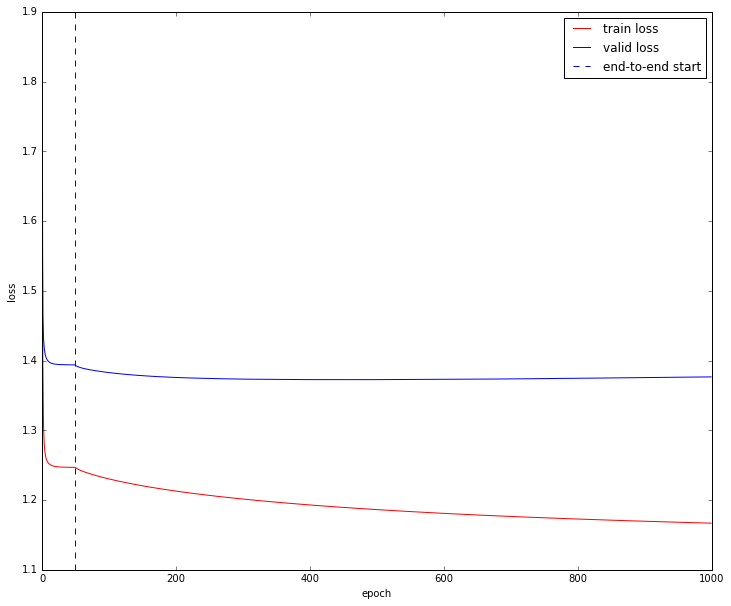

In [51]:
plt.figure(figsize=(12,10))
plt.plot(train_loss_history, color="red", label="train loss")
plt.plot(valid_loss_history, color="blue", label="valid loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.axvline(end_to_end_start-1, ls = "--", label="end-to-end start")
plt.legend()
plt.show()

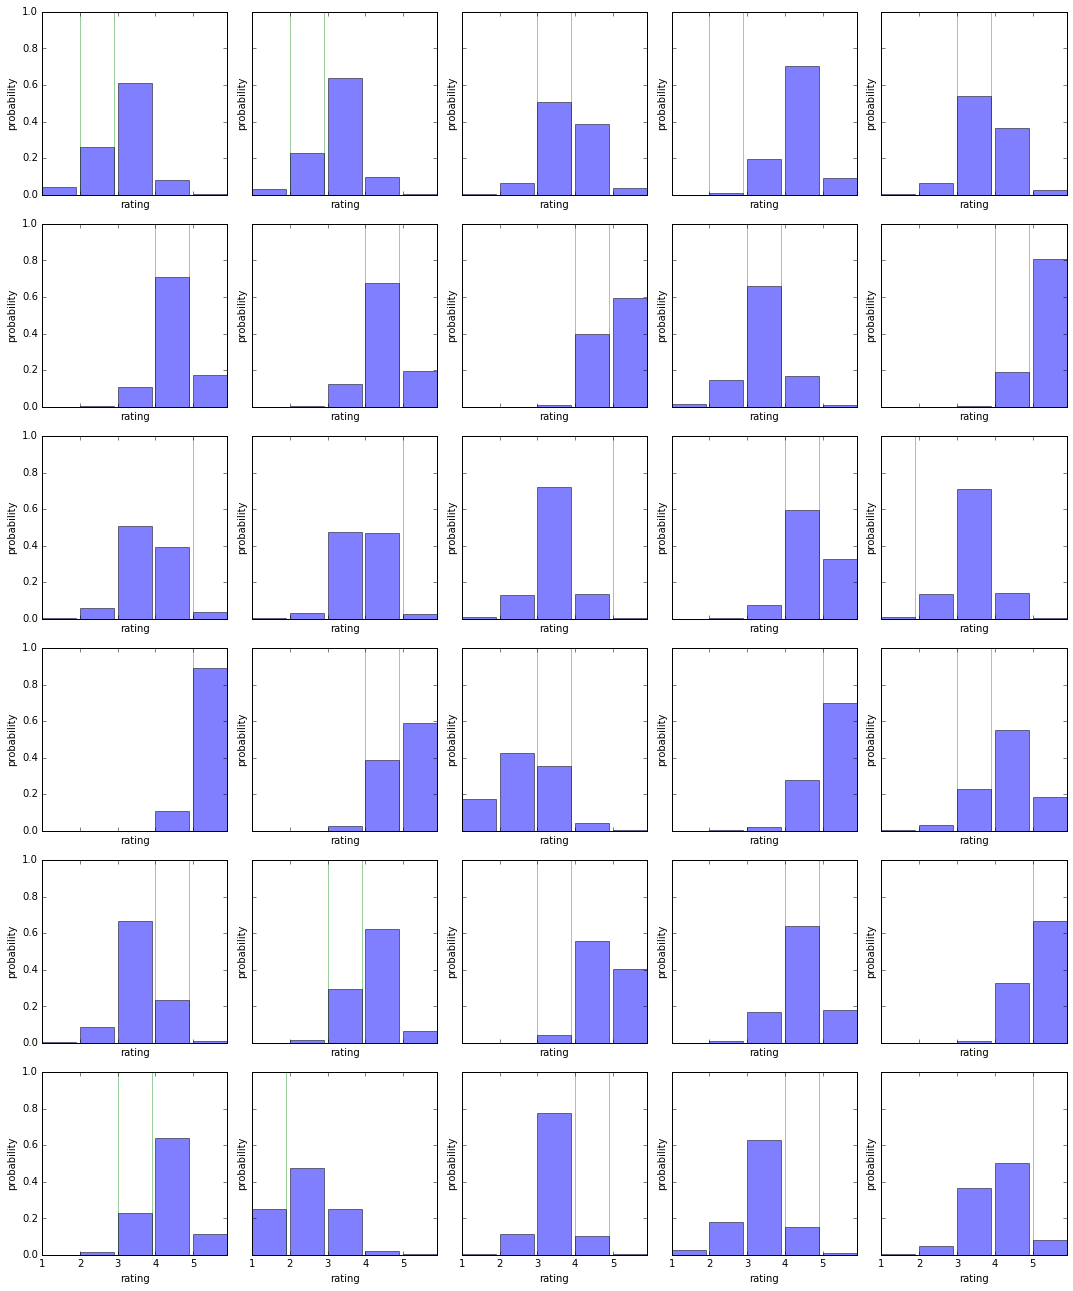

In [52]:
n_cols, n_rows = 5, 6
n = n_cols * n_rows
ratings = validset.rating.values[:n]
probs = final_valid_predictions[:n]

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3), sharex=True, sharey=True)
for ax, r, ps  in zip(axs.flatten(), ratings, probs):
    for i, p in enumerate(ps):
        ax.set_xlabel("rating")
        ax.set_ylabel("probability")
        ax.bar(r, 1, .9, color="white", edgecolor="green", alpha=.1, zorder=1)
        ax.bar(i+1, p, .9, color="blue", alpha=.5, edgecolor="black", zorder=2)
        ax.set_xticks(np.arange(1, 6))
    #ax.bar(np.argmax(ps, axis=-1)+1, 1, .9, color="red", edgecolor="red", alpha=.1, zorder=1)
fig.tight_layout()

In [53]:
results = validset[["gender", "userid","movieid","age_desc","occ_desc", "title", "genre", "rating"]].copy()
results["prediction"] = final_valid_predictions.argmax(axis=1)+1
results["rating 1"] = final_valid_predictions[:,0]
results["rating 2"] = final_valid_predictions[:,1]
results["rating 3"] = final_valid_predictions[:,2]
results["rating 4"] = final_valid_predictions[:,3]
results["rating 5"] = final_valid_predictions[:,4]
results.head(10)

,gender,userid,movieid,age_desc,occ_desc,title,genre,rating,prediction,rating 1,rating 2,rating 3,rating 4,rating 5
656218,F,5107,2406,45-49,other or not specified,Romancing the Stone (1984),Action|Adventure|Comedy|Romance,2,3,0.041350,0.263017,0.608964,0.082422,0.004247
802900,M,2496,2988,50-55,academic/educator,Melvin and Howard (1980),Drama,2,3,0.031366,0.228283,0.639892,0.095752,0.004707
477345,M,5536,1693,25-34,self-employed,Amistad (1997),Drama,3,3,0.005216,0.065582,0.508156,0.385236,0.035811
256823,F,4085,1049,25-34,doctor/health care,"Ghost and the Darkness, The (1996)",Action|Adventure,2,4,0.000208,0.007229,0.195495,0.706333,0.090735
668537,M,462,2454,18-24,self-employed,"Fly, The (1958)",Horror|Sci-Fi,3,3,0.004341,0.063588,0.541756,0.363103,0.027211
192126,M,2414,750,25-34,academic/educator,Dr. Strangelove or: How I Learned to Stop Worr...,Sci-Fi|War,4,4,0.000075,0.003175,0.110125,0.711519,0.175106
841841,M,4570,3147,45-49,technician/engineer,"Green Mile, The (1999)",Drama|Thriller,4,4,0.000157,0.004762,0.121376,0.679181,0.194524
785100,M,5281,2918,25-34,artist,Ferris Bueller's Day Off (1986),Comedy,4,5,0.000001,0.000103,0.009645,0.395210,0.595041
117944,M,1803,438,25-34,artist,"Cowboy Way, The (1994)",Action|Comedy,3,3,0.015664,0.146682,0.660807,0.167358,0.009489
631594,F,5986,2336,56+,academic/educator,Elizabeth (1998),Drama,4,5,0.000002,0.000078,0.003952,0.189374,0.806595


In [54]:
def compute_recall(prediction_col, target_col):
    recall=[]
    for i in range(5):
        rating_df = results[results[target_col]==i+1]
        num_true_rating = len(rating_df)+0.0
        current_recall = (len(rating_df[rating_df[prediction_col]==i+1]))/float(num_true_rating)
        recall.append(current_recall)
    return recall

def compute_precision(prediction_col, target_col): 
    precision=[]
    for i in range(5):
        pred_df = results[results[prediction_col]==i+1]
        pred_rating = len(pred_df)+0.0
        current_precision = (len(pred_df[pred_df[target_col]==i+1]))/float(pred_rating)
        precision.append(current_precision)
    return precision    

def compute_mae(prediction_col, target_col):
    return np.mean(np.abs(results[prediction_col]-results[target_col]))

def compute_rmse(prediction_col, target_col):
    return np.sqrt(1/float(len(results))*np.sum((results[prediction_col]- results[target_col])**2))

In [55]:
compute_recall('prediction', 'rating')

[0.23305185537583253,
 0.19579358196010407,
 0.4832799601934192,
 0.6137722545896354,
 0.39831019028726766]

In [56]:
compute_precision('prediction', 'rating')

[0.5985033598045205,
 0.34864864864864864,
 0.41097332074775683,
 0.46302016425859904,
 0.6070452814977382]

In [57]:
compute_mae('prediction', 'rating')

0.63955569330440609

In [58]:
compute_rmse('prediction', 'rating')

0.93621895609622841